# Optimal Baseball

In [6]:
import numpy
from scipy.interpolate import interp1d
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [7]:
params = modsim.Params(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,     # s
)

In [8]:
params = params.set(
    wall_distance = 94.4880,
    wall_height = 11.2776,
)

modsim.show(params)

,value
x,0.0000
y,1.0000
angle,45.0000
speed,40.0000
mass,0.1450
diameter,0.0730
C_d,0.3300
rho,1.2000
g,9.8000
t_end,10.0000


In [9]:
def make_system(params):
    
    # convert angle to degrees
    theta = numpy.deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = modsim.pol2cart(theta, params.speed)
    
    # make the initial state
    init = modsim.State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = numpy.pi * (params.diameter/2)**2

    return modsim.System(params,
                         init = init,
                         area = area)

In [10]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * modsim.vector_mag(V)**2 * C_d * area / 2
    direction = - modsim.vector_hat(V)
    f_drag = mag * direction
    return f_drag

In [11]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

In [12]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = modsim.Vector(vx, vy) # velocity
    
    a_drag = drag_force(V, system) / mass
    a_grav = g * modsim.Vector(0, -1)
    A = a_grav + a_drag # acceleration
    
    return V.x, V.y, A.x, A.y

In [13]:
def range_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = modsim.run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    print(angle, x_dist)
    return x_dist

In [14]:
range_func(45, params)

45 99.31829628352205


99.31829628352205

In [15]:
angles = numpy.linspace(20, 80, 21)
sweep = modsim.SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

20.0 78.09741067882733
23.0 84.11542610650984
26.0 89.13192412363972
29.0 93.17466724082831
32.0 96.2713473739135
35.0 98.44725560274011
38.0 99.72474586365277
41.0 100.12347299697635
44.0 99.66100302635334
47.0 98.3535476368483
50.0 96.21673516565129
53.0 93.26623796736264
56.0 89.51751617672979
59.0 84.98724481958084
62.0 79.69434524339994
65.0 73.66129770133254
68.0 66.91470886279745
71.0 59.48269492939725
74.0 51.4028710994044
77.0 42.720479255334496
80.0 33.484379808139316


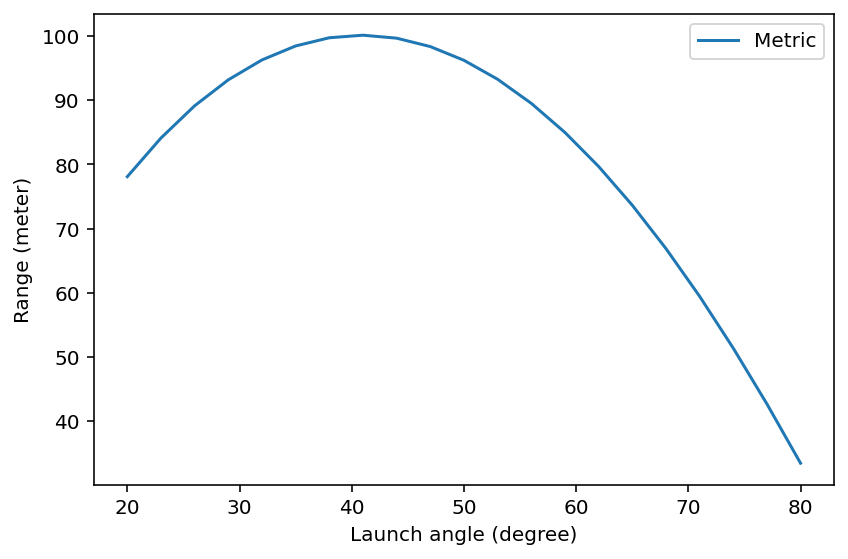

In [16]:
sweep.plot()

modsim.decorate(xlabel='Launch angle (degree)',
         ylabel='Range (meter)')

In [17]:
res = modsim.maximize_scalar(range_func, params, bounds=[0, 90])

0 17.468795355645703
34.37694101250946 98.06996498016369
55.62305898749054 90.03182421721924
21.246117974981075 80.72039493627989
41.173855871043976 100.12001889316983
40.98012090783802 100.12368377099193
40.88213731907448 100.12417004431842
40.879254201231156 100.12417043309698
40.87928713855166 100.12417043314983
40.879291078222806 100.12417043314913
40.879283198880515 100.12417043314889


In [18]:
res

     fun: 100.12417043314983
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 40.87928713855166

In [19]:
res.x, res.fun

(40.87928713855166, 100.12417043314983)

### Exercise 1
Let’s finish off the Manny Ramirez problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Although the problem asks for a minimum, it is not an optimization problem. Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by “optimal”. For this problem, we don’t want the longest range; we want the maximum height at the point where it reaches the wall.

In [31]:
def event_func_2(t, state, system):
    x, y, vx, vy = state
    return x - system.wall_distance

In [32]:
system = make_system(params)

In [33]:
event_func_2(0, system.init, system)

-94.488

In [34]:
def height_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    
    results, details = modsim.run_solve_ivp(
        system, slope_func, 
        events=event_func_2,
    )
    
    height = results.iloc[-1].y
    return height

In [36]:
height_func(40, params)

6.661045303535722

In [37]:
res_2 = modsim.maximize_scalar(height_func, params, bounds=[0, 90])

In [39]:
res_2

     fun: 7.217049532932904
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 43.10508097897547

In [38]:
res_2.x, res_2.fun

(43.10508097897547, 7.217049532932904)

In [52]:
# Function that estsimates the speed neccessary to reach the wall height
def error_func(speed, params):
    params = params.set(speed=speed)
    res = modsim.maximize_scalar(height_func, params, bounds=[0, 90])
    return res.fun - params.wall_height

In [53]:
error_func(40, params)

-4.060550467067095

In [54]:
results = modsim.root_scalar(error_func, params, bracket=[30, 50])

In [55]:
results

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 41.039294634028856

In [56]:
error_func(results.root, params)


0.0010039392294949323